### Task: Multigrid

Consider the following linear system
\begin{equation}
\ A * u = f, (1)
\end{equation}
or equivalently
\begin{equation}
\ u = \underset{v \in \mathbb{R}^{n \times n}}{\mathrm{argmin}} \, \frac{1}{2} (A * v, v)_F - (f, v)_F, (2)
\end{equation}
where $u, v, f \in \mathbb{R}^{n \times n}$ and $(f, v)_F = \sum_{i,j=1}^{n} f_{ij} v_{ij}$ is the Frobenius inner product.

For $J = 4$, $n = 2^J-1$ and the number of iterations $M=100$. We use the $\textbf{gradient descent}$ method and the $\textbf{multigrid method}$ to solve the above problem with a random initial guess $u_0$. Let $u_{GD}$ and $u_{MD}$ denote the solutions obtained by gradient descent for problem in (2) and multigrid for problem in (1)

Firstly, let us implement $\textbf{gradient descent}$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

# Define the constant convolution kernel for the Laplace operator
Laplace_kernel = torch.tensor([[[[0, -1, 0],
                                 [-1, 4, -1],
                                 [0, -1, 0]]]], dtype=torch.float32)

# Define the convolution kernel for the smoother for Laplacian operator
Smoother_kernel = torch.tensor([[[[0, 1/64, 0],
                                   [1/64, 12/64, 1/64],
                                   [0, 1/64, 0]]]], dtype=torch.float32)

class GradientDescentIteration(nn.Module):
    def __init__(self, channels=1, multigrid=False):
        super().__init__()
        self.lap = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.s = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        if multigrid:
            self.lap.weight = nn.Parameter(Laplace_kernel.repeat(channels, 1, 1, 1))
            self.s.weight = nn.Parameter(Smoother_kernel.repeat(channels, 1, 1, 1))

    def forward(self, out):
        u, b = out
        u = u + self.s(b - self.lap(u))
        return u, b

Next, let us implement the $\textbf{multigrid method}$.

In [2]:
# Define the constant convolution kernel for the Laplace operator
Laplace_kernel = torch.tensor([[[[0, -1, 0],
                                 [-1, 4, -1],
                                 [0, -1, 0]]]], dtype=torch.float32)

# Define the prolongation convolutional kernel for multigrid
Prolongation_kernel = torch.tensor([[[[0, 0.5, 0.5],
                                      [0.5, 1, 0.5],
                                      [0.5, 0.5, 0]]]], dtype=torch.float32)

# Define the restriction convolutional kernel with zeros
Pi_kernel = torch.tensor([[[[0, 0, 0],
                            [0, 0, 0],
                            [0, 0, 0]]]], dtype=torch.float32)

# Define the convolution kernel for the smoother for Laplacian operator
Smoother_kernel = torch.tensor([[[[0, 1/64, 0],
                                   [1/64, 12/64, 1/64],
                                   [0, 1/64, 0]]]], dtype=torch.float32)

class Restriction(nn.Module):
    def __init__(self, channels=1, multigrid=False):
        super().__init__()
        self.restrict_b = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=0, bias=False)
        self.restrict_u = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=0, bias=False)
        self.lap = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        if multigrid:
            self.restrict_b.weight = nn.Parameter(Prolongation_kernel.repeat(channels, 1, 1, 1))
            self.restrict_u.weight = nn.Parameter(Pi_kernel.repeat(channels, 1, 1, 1))
            self.lap.weight = nn.Parameter(Laplace_kernel.repeat(channels, 1, 1, 1))

    def forward(self, out):
        u_old, b_old = out
        u = self.restrict_u(u_old)
        b = self.restrict_b(b_old - self.lap(u_old)) + self.lap(u)
        return u, b

class Prolongation(nn.Module):
    def __init__(self, channels=1, multigrid=False):
        super().__init__()
        self.prolong = nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=2, padding=0, bias=False)
        if multigrid:
            self.prolong.weight = nn.Parameter(Prolongation_kernel)

    def forward(self, u):
        u_prolonged = self.prolong(u)
        return u_prolonged

class Multigrid(nn.Module):
    def __init__(self, num_channels, num_classes, num_iterations=[2, 2, 2, 2], multigrid=False):
        super().__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.num_iterations = num_iterations
        self.multigrid = multigrid
        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()
        downlayer, uplayer = [], []
        for i in range(len(num_iterations)):
            for _ in range(num_iterations[i]):
                downlayer.append(GradientDescentIteration(num_channels, multigrid))
                uplayer.append(GradientDescentIteration(num_channels, multigrid))
            self.down_layers.append(nn.Sequential(*downlayer))
            self.up_layers.append(nn.Sequential(*uplayer))
            downlayer, uplayer = [], []
            if i < len(num_iterations) - 1:
                downlayer.append(Restriction(num_channels, multigrid))
        self.upsamples_layers = nn.ModuleList()
        for i in range(len(num_iterations) - 1):
            self.upsamples_layers.append(Prolongation(num_channels, multigrid))

    def forward(self, out):
        out_list = []
        for i in range(len(self.num_iterations)):
            out = self.down_layers[i](out)
            out_list.append(out)
        for j in range(len(self.num_iterations) - 2, -1, -1):
            u_up, f = out_list[j][0], out_list[j][1]
            u_down, f_down = out_list[j + 1][0], out_list[j+1][1]
            u_up = u_up + self.upsamples_layers[j](u_down)
            out = (u_up, f)
            out_list[j] = self.up_layers[j](out)
        return out

Now let us compare these two approaches.

1. Let us plot the surface of solution $u_{GD}$ and $u_{MG}$ for $M=100$ number of iterations.

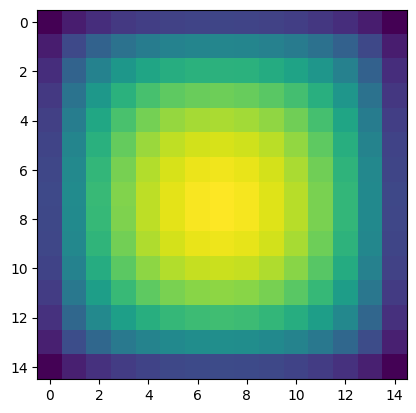

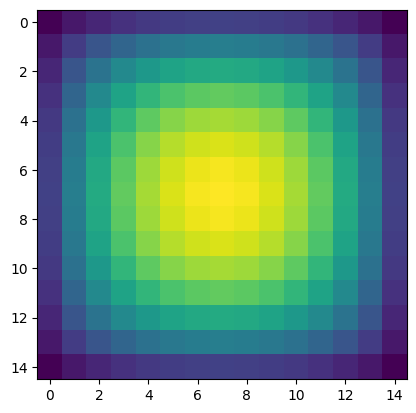

In [3]:
# Initialization
u = torch.randn(1, 1, 15, 15)
b = torch.ones(1, 1, 15, 15) / 16**2

gd = GradientDescentIteration(multigrid=True)
residuals_gd = []
out = (u, b)
for i in range(100):
    out = gd(out)
    error = torch.norm(F.conv2d(out[0], Laplace_kernel, padding=1) - out[1]).item()
    residuals_gd.append(error)
out_gd_final = out

mg = Multigrid(num_channels=1, num_classes=1, num_iterations=[2, 2, 2, 2], multigrid=True)
residuals_mg = []
out = (u, b)
for i in range(100):
    out = mg(out)
    error = torch.norm(F.conv2d(out[0], Laplace_kernel, padding=1) - out[1]).item()
    residuals_mg.append(error)
out_mg_final = out

plt.imshow(out_gd_final[0].squeeze().detach().numpy())
plt.show()
plt.imshow(out_mg_final[0].squeeze().detach().numpy())
plt.show()

2. Let us plot the errors for these methods as a function of the number of iterations. We initially set $M=1000$, and then stop training when the error becomes less than $10^{-5}$, for gradient descent, we denote this step as $m_1$, and for multigrid, we denote it as $m_2$.

   From the plot we can see that the multigrid method converges much faster than gradient descent.

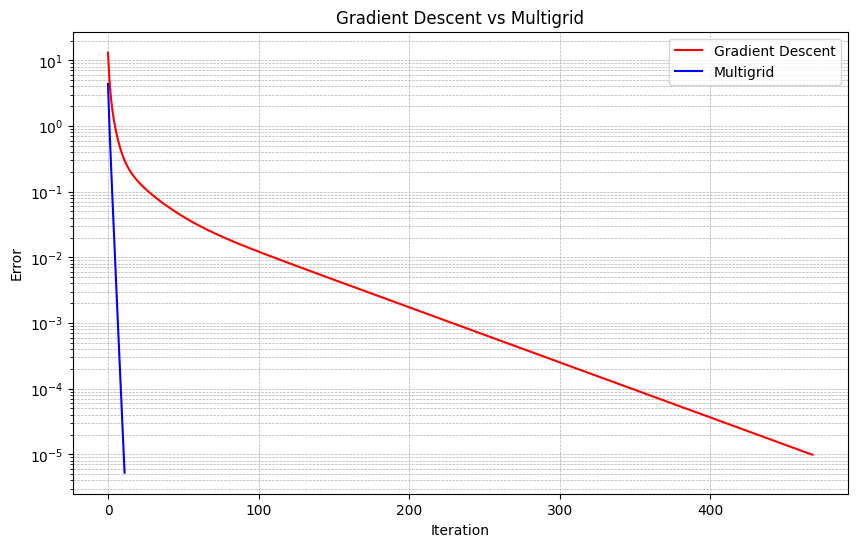

In [4]:
# Initialization
u = torch.randn(1, 1, 15, 15)
b = torch.ones(1, 1, 15, 15) / 16**2

gd = GradientDescentIteration(multigrid=True)
residuals_gd = []
out = (u, b)
for i in range(1000):
    out = gd(out)
    error = torch.norm(F.conv2d(out[0], Laplace_kernel, padding=1) - out[1]).item()
    residuals_gd.append(error)
    if error < 10**(-5):
        m1 = i
        out_gd_final = out
        break

mg = Multigrid(num_channels=1, num_classes=1, num_iterations=[2, 2, 2, 2], multigrid=True)
residuals_mg = []
out = (u, b)
for i in range(1000):
    out = mg(out)
    error = torch.norm(F.conv2d(out[0], Laplace_kernel, padding=1) - out[1]).item()
    residuals_mg.append(error)
    if error < 10**(-5):
        m2 = i
        out_mg_final = out
        break

plt.figure(figsize=(10, 6))
plt.plot(residuals_gd, label='Gradient Descent', color='red')
plt.plot(residuals_mg, label='Multigrid', color='blue')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Gradient Descent vs Multigrid')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

3. Now let us print $m_1$ and $m_2$. We can notice that $m_1 >> m_2$.

In [5]:
print('m_1: ', m1)
print('m_2: ', m2)

m_1:  468
m_2:  11


### Task MgNet

1. In this part, we modify the Multigrid code to implement MgNet. Specifically, we incorporate the following modifications:

   (a) Adding nonlinear activation functions and BatchNormalization (BN). Batch Normalization should be applied after convolution layers and before activation functions in the Feature extraction (pre-smoothing) part of the Multigrid method.

   (b) We do not need activation function or BN for the Interpolation and Restriction in MgNet. In the multigrid framework, the interpolation and restriction operations are used to transfer information between different grid levels (fine-to-coarse or coarse-to-fine). These operations are typically linear and do not require non-linearities like activation functions or normalization like BN.

2. Now, let us train MgNet model for CIFAR-10 dataset.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GradientDescentIteration(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        self.lap = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.s = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, out):
        u, b = out
        u = u + F.relu(self.bn2(self.s(F.relu(self.bn1(b - self.lap(u))))))
        u = self.dropout(u)
        return u, b

class Restriction(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        self.restrict_b = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.restrict_u = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.lap = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, out):
        u_old, b_old = out
        u = self.restrict_u(u_old)
        b = self.restrict_b(b_old - self.lap(u_old)) + self.lap(u)
        u = self.dropout(u)
        return u, b

class MultigridClassification(nn.Module):
    def __init__(self, num_channels, num_classes, num_iterations=[2, 2, 2, 2]):
        super().__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.num_iterations = num_iterations
        self.lift = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, )
        self.down_layers = nn.ModuleList()
        downlayer = []
        for i in range(len(num_iterations)):
            for _ in range(num_iterations[i]):
                downlayer.append(GradientDescentIteration(num_channels))
            self.down_layers.append(nn.Sequential(*downlayer))
            downlayer = []
            if i < len(num_iterations) - 1:
                downlayer.append(Restriction(num_channels))
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(num_channels, num_classes)

    def forward(self, u, b):
        u = self.lift(u)
        b = self.lift(b)
        out = (u, b)
        for i in range(len(self.num_iterations)):
            out = self.down_layers[i](out)
        u, _ = out
        u = F.adaptive_avg_pool2d(u, (1, 1))
        u = u.view(u.size(0), -1)
        u = self.dropout(u)
        out = self.classifier(u)
        return out

In [7]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the transformations (converting images to tensor)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 training and testing datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create data loaders for the training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|█████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:10<00:00, 15857316.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
import torch.optim as optim

# Define the training loop
def train_epoch(model, loader, optimizer, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    scheduler.step()
    return train_loss / (batch_idx + 1), 100. * correct / total

# Define the test loop
def test_epoch(model, loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, inputs)
            loss = F.cross_entropy(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return test_loss / (batch_idx + 1), 100. * correct / total

# Define the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and optimizer
model = MultigridClassification(num_channels=128, num_classes=10)
model.to(device)
optimizer = optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Training loop
for epoch in range(100):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc = test_epoch(model, test_loader, device)
    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, '
          f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}')

Epoch 1: Train Loss: 1.693, Train Acc: 37.428, Test Loss: 1.306, Test Acc: 53.450
Epoch 2: Train Loss: 1.303, Train Acc: 52.940, Test Loss: 1.159, Test Acc: 58.860
Epoch 3: Train Loss: 1.155, Train Acc: 58.564, Test Loss: 0.966, Test Acc: 65.870
Epoch 4: Train Loss: 1.057, Train Acc: 62.178, Test Loss: 0.898, Test Acc: 68.540
Epoch 5: Train Loss: 0.990, Train Acc: 64.930, Test Loss: 0.841, Test Acc: 70.650
Epoch 6: Train Loss: 0.932, Train Acc: 67.018, Test Loss: 0.846, Test Acc: 71.400
Epoch 7: Train Loss: 0.872, Train Acc: 69.176, Test Loss: 0.757, Test Acc: 74.780
Epoch 8: Train Loss: 0.824, Train Acc: 71.264, Test Loss: 0.669, Test Acc: 77.150
Epoch 9: Train Loss: 0.775, Train Acc: 73.020, Test Loss: 0.656, Test Acc: 77.940
Epoch 10: Train Loss: 0.742, Train Acc: 74.148, Test Loss: 0.587, Test Acc: 80.560
Epoch 11: Train Loss: 0.700, Train Acc: 75.596, Test Loss: 0.568, Test Acc: 81.690
Epoch 12: Train Loss: 0.675, Train Acc: 76.690, Test Loss: 0.567, Test Acc: 81.620
Epoch 13: Tra

Epoch 100: Train Loss: 0.107, Train Acc: 96.198, Test Loss: 0.226, Test Acc: 94.710
